# Análise Estatística dos Resultados de Performance (JMeter .jtl)
Este notebook lê e analisa automaticamente os arquivos de resultados de testes de performance localizados em `results/`, gerando estatísticas e gráficos para facilitar a avaliação dos experimentos.

## 1. Ingestão e metadata

In [88]:
from pathlib import Path
import pandas as pd
import numpy as np

def get_jtl_files(base='results'):
    return sorted(Path(base).rglob('*.jtl'))

def parse_metadata(fp):
    parts   = Path(fp).parts
    scenario = parts[1]                      # ex: 'sas_full_flow_high'
    run_id   = Path(fp).stem.split('_')[1]   # ex: '1', '2', ...
    return scenario, run_id

jtl_files = get_jtl_files()

dfs = []
for f in jtl_files:
    df = pd.read_csv(f)
    scenario, run_id = parse_metadata(f)

    df['scenario']     = scenario
    df['run']          = run_id
    df['request_type'] = df['label']       # pega o nome do sampler no JMeter

    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)


print(all_data)


           timeStamp  elapsed           label  responseCode responseMessage  \
0      1751464547406       67      Authorize            200              OK   
1      1751464547475       34    Registration           200              OK   
2      1751464547510       31           Grant           200              OK   
3      1751464547588       39  Relinquishment           200              OK   
4      1751464547628       40  Deregistration           200              OK   
...              ...      ...             ...           ...             ...   
26515  1751465425764       29    Registration           200              OK   
26516  1751465425793       51           Grant           200              OK   
26517  1751465425844       82  Relinquishment           200              OK   
26518  1751465425926       54  Deregistration           200              OK   
26519  1751465425980       27          Revoke           200              OK   

                                   threadName dataT

## 2. Tempo relativo

In [89]:
# 1) Certifique-se de que timeStamp é datetime
all_data['timeStamp'] = pd.to_datetime(all_data['timeStamp'], unit='ms')

# 2) Criar coluna de tempo relativo (segundos desde o início de CADA run dentro de cada cenário)
all_data['time_rel'] = (
    all_data
    .groupby(['scenario','run'])['timeStamp']
    .transform(lambda ts: (ts - ts.min()).dt.total_seconds())
)

print(all_data)


                    timeStamp  elapsed           label  responseCode  \
0     2025-07-02 13:55:47.406       67      Authorize            200   
1     2025-07-02 13:55:47.475       34    Registration           200   
2     2025-07-02 13:55:47.510       31           Grant           200   
3     2025-07-02 13:55:47.588       39  Relinquishment           200   
4     2025-07-02 13:55:47.628       40  Deregistration           200   
...                       ...      ...             ...           ...   
26515 2025-07-02 14:10:25.764       29    Registration           200   
26516 2025-07-02 14:10:25.793       51           Grant           200   
26517 2025-07-02 14:10:25.844       82  Relinquishment           200   
26518 2025-07-02 14:10:25.926       54  Deregistration           200   
26519 2025-07-02 14:10:25.980       27          Revoke           200   

      responseMessage                              threadName dataType  \
0                  OK     SAS Full Flow Thread Group High 1-1

## 3. Estatísticas por run

Calcule contagem, média, p50, p90, p99 da latência em cada run:

In [90]:
per_run = (
    all_data
    .groupby(['scenario','request_type','run'])['elapsed']
    .agg(
      count='count',
      mean='mean',
      p50=lambda x: x.median(),
      p90=lambda x: np.percentile(x, 90),
      p99=lambda x: np.percentile(x, 99),
      std='std'
    )
    .reset_index()
)

## 4. Agregação sobre runs

In [91]:
agg_runs = (
    per_run
    .groupby(['scenario','request_type'])
    .agg(
      mean_of_means=('mean','mean'),
      std_of_means=('mean','std'),
      cv=('mean', lambda x: x.std()/x.mean()),
      median_of_p50=('p50','median'),
      mean_p90=('p90','mean'),
      mean_p99=('p99','mean')
    )
    .reset_index()
)

from scipy import stats

def ci95(x):
    m, s, n = x.mean(), x.std(ddof=1), len(x)
    h = stats.t.ppf(0.975, n-1) * s/np.sqrt(n)
    return pd.Series({'mean':m,'ci95_low':m-h,'ci95_high':m+h})

ci = (
    per_run
    .groupby(['scenario','request_type'])['mean']
    .apply(ci95)
    .reset_index()
)


## 5. Visualizações
Boxplot agregado (todas as runs juntas):

AttributeError: 'NoneType' object has no attribute 'remove'

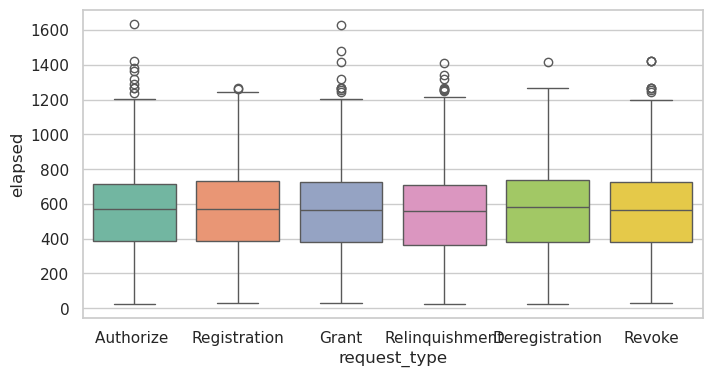

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

for scenario, grp in all_data.groupby('scenario'):
    plt.figure(figsize=(8,4))
    ax = sns.boxplot(
        data=grp,
        x='request_type',
        y='elapsed',
        hue='request_type',   # <- atribui hue
        dodge=False,          # sobrepõe as caixas (um único box por categoria)
        palette='Set2'
    )
    plt.title(f'{scenario} — Latência Agregada')
    plt.xlabel('Tipo de Requisição')
    plt.ylabel('Tempo (ms)')
    plt.tight_layout()
    plt.show()


### Série temporal dos tempos de resposta

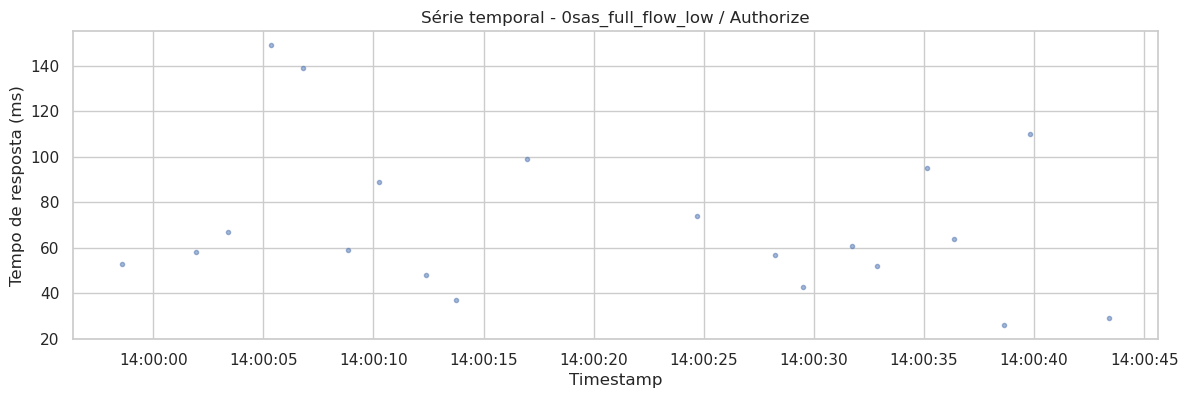

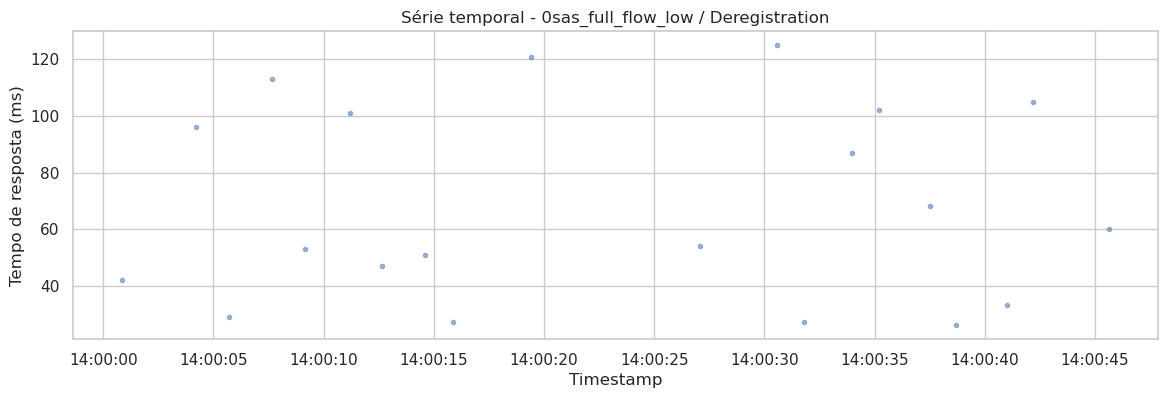

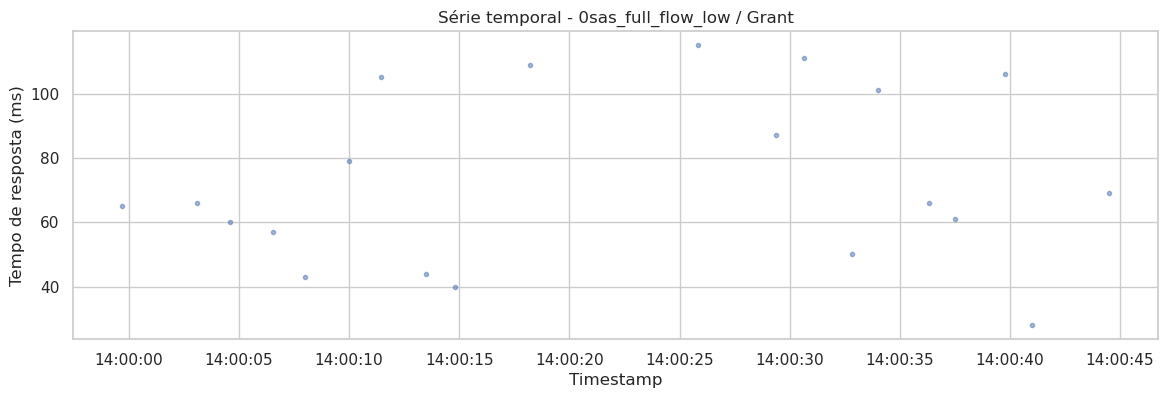

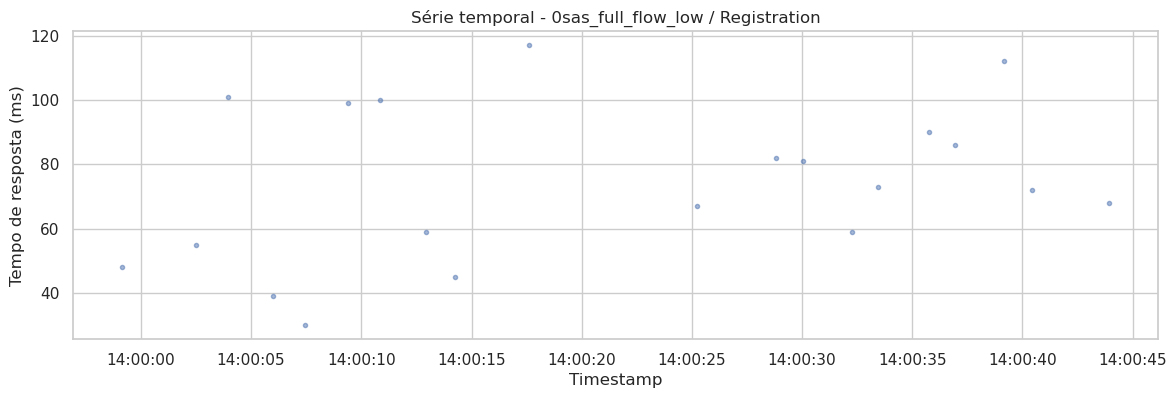

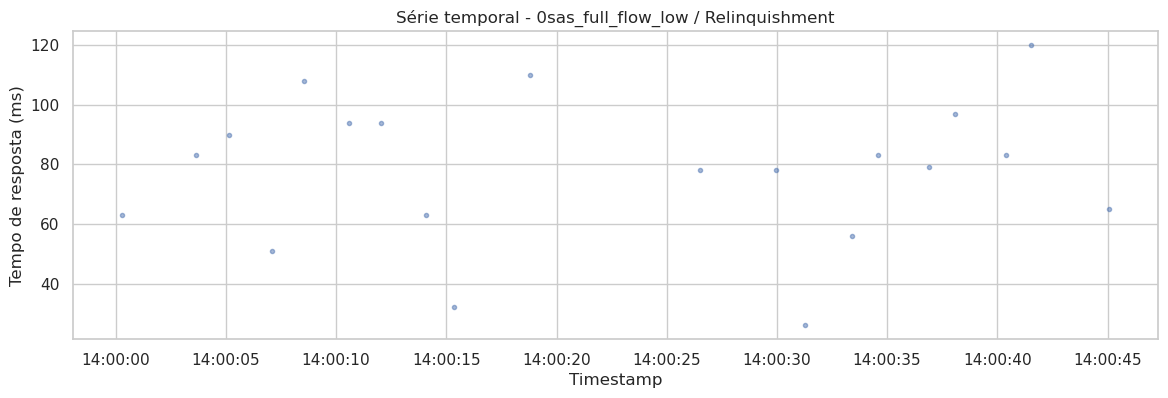

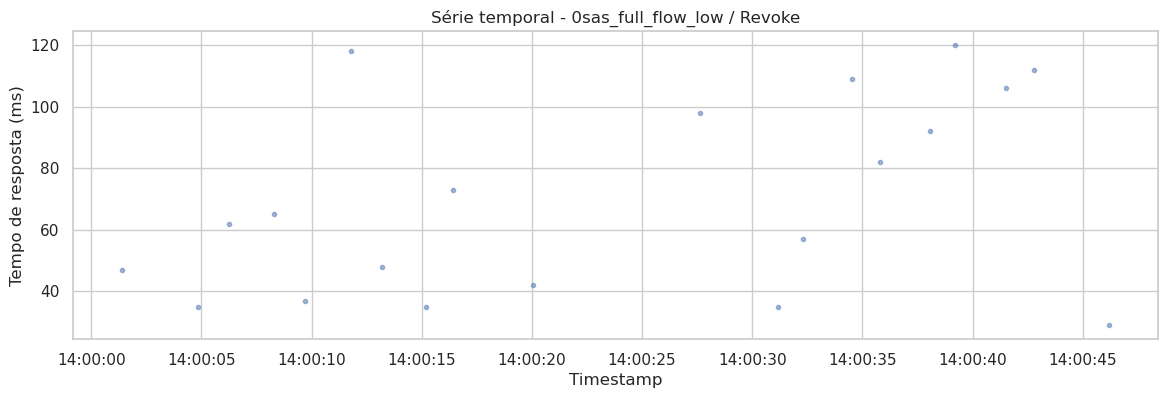

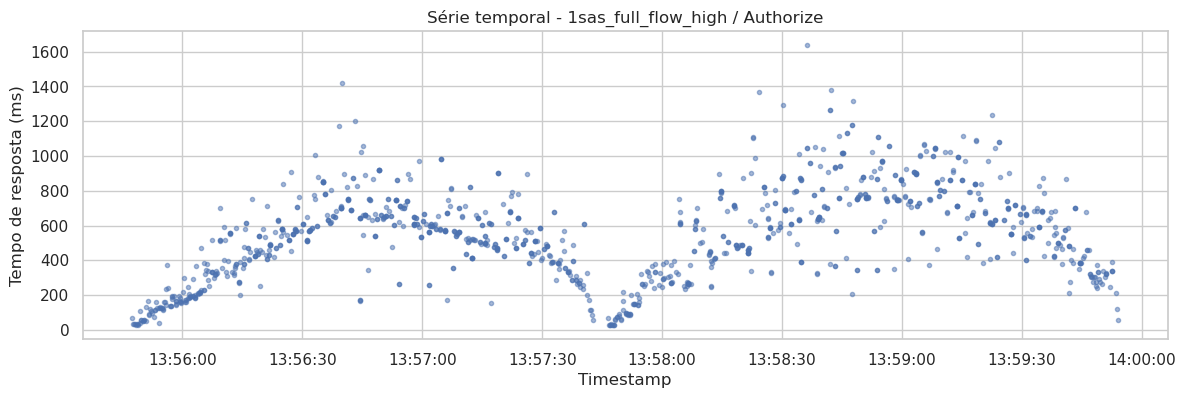

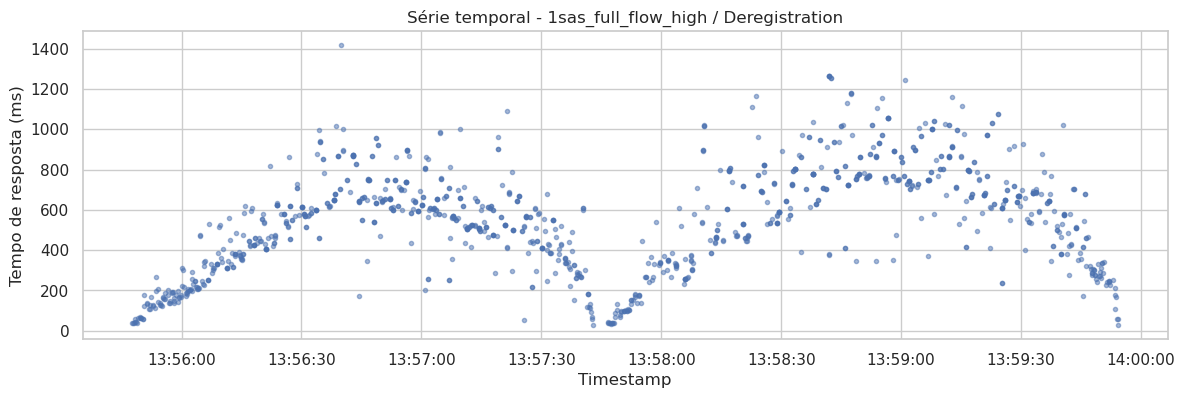

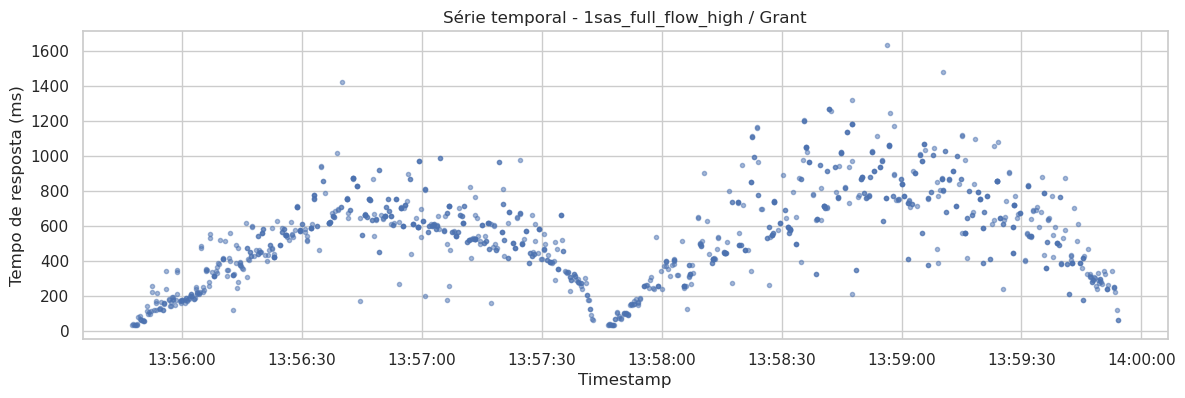

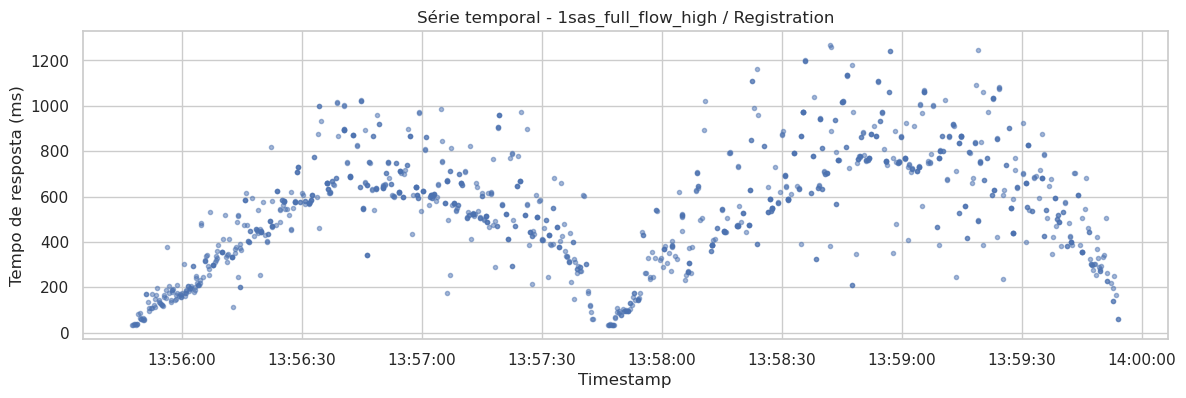

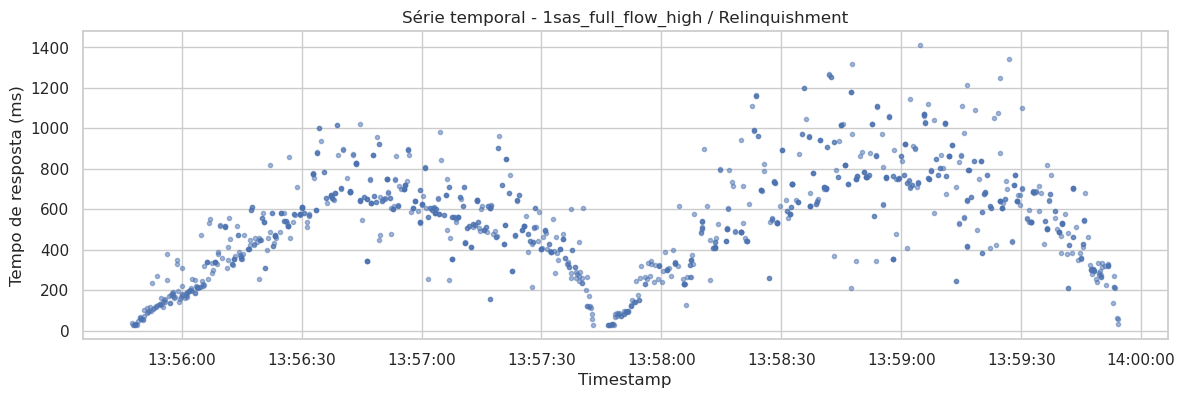

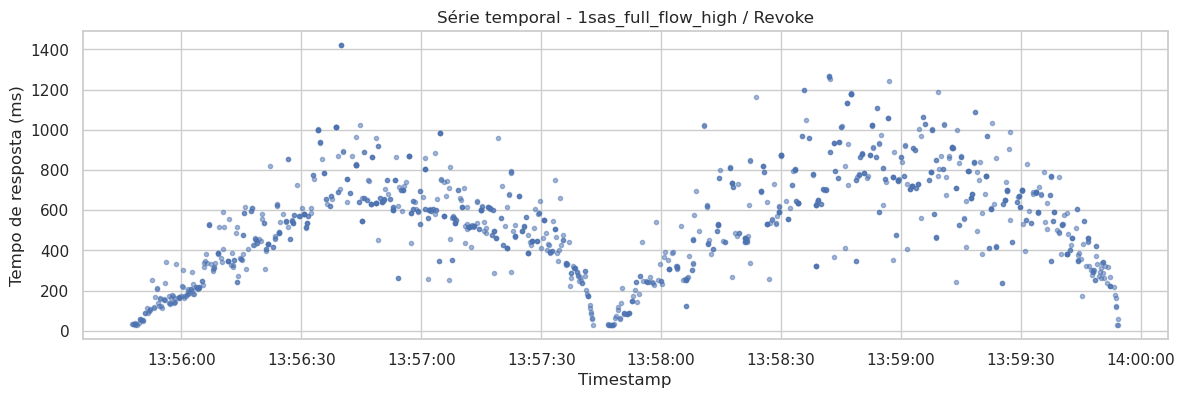

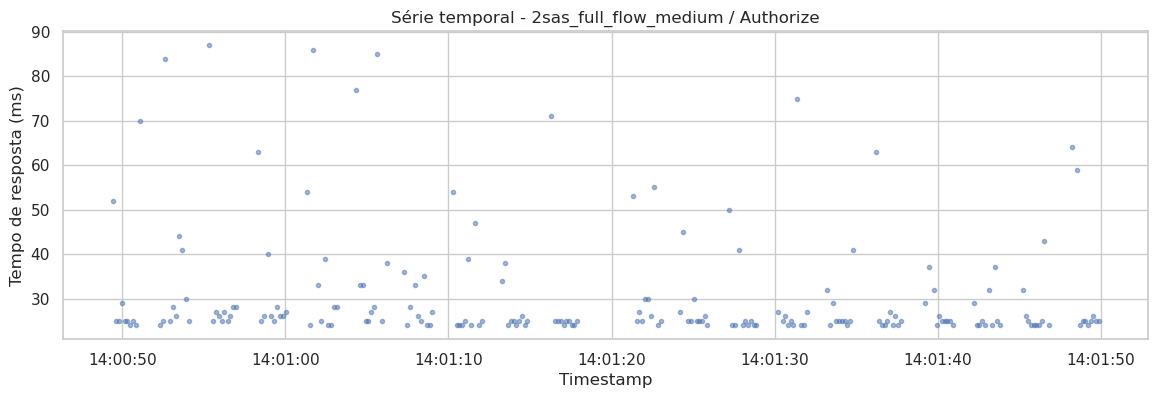

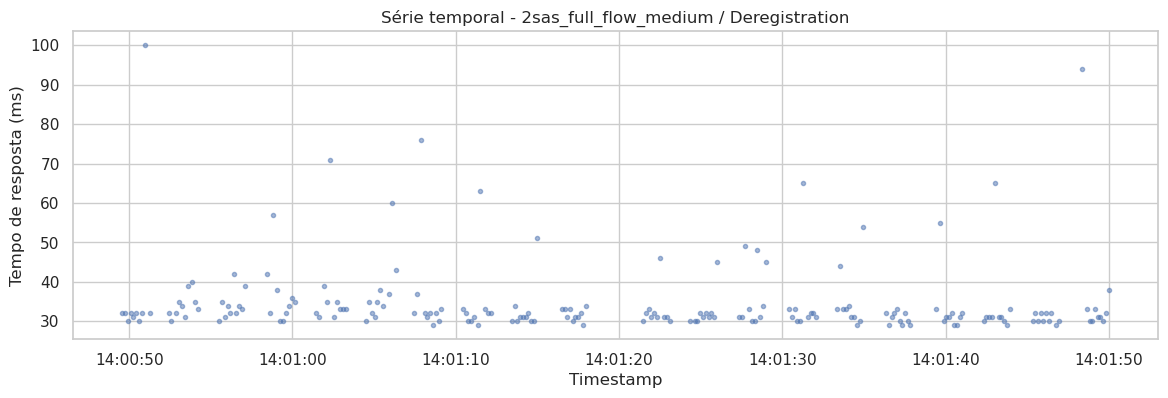

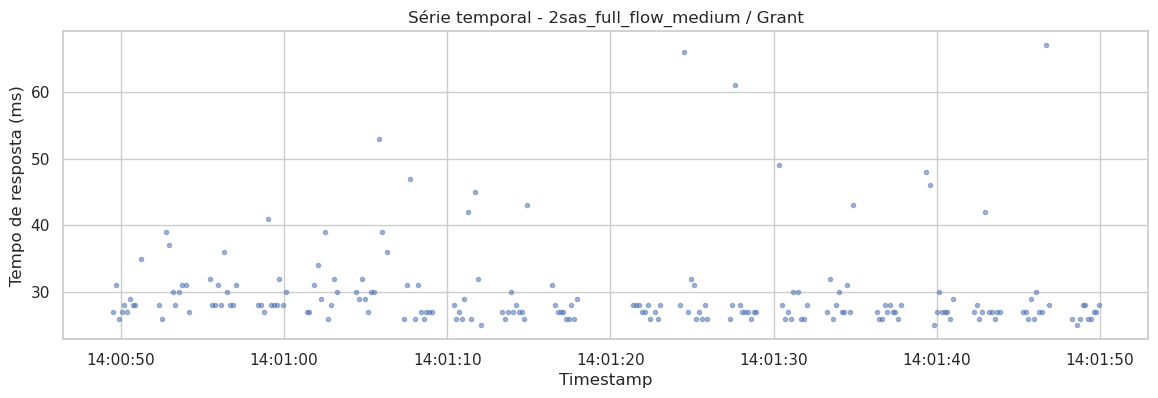

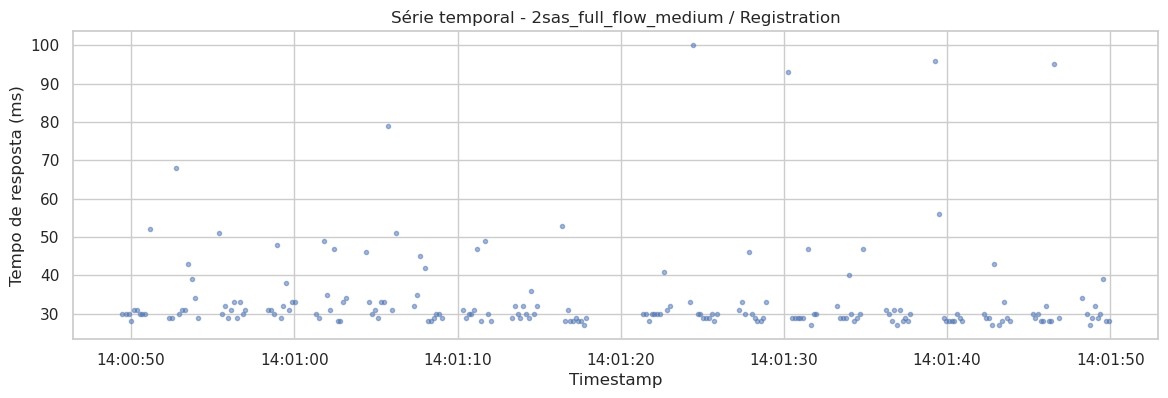

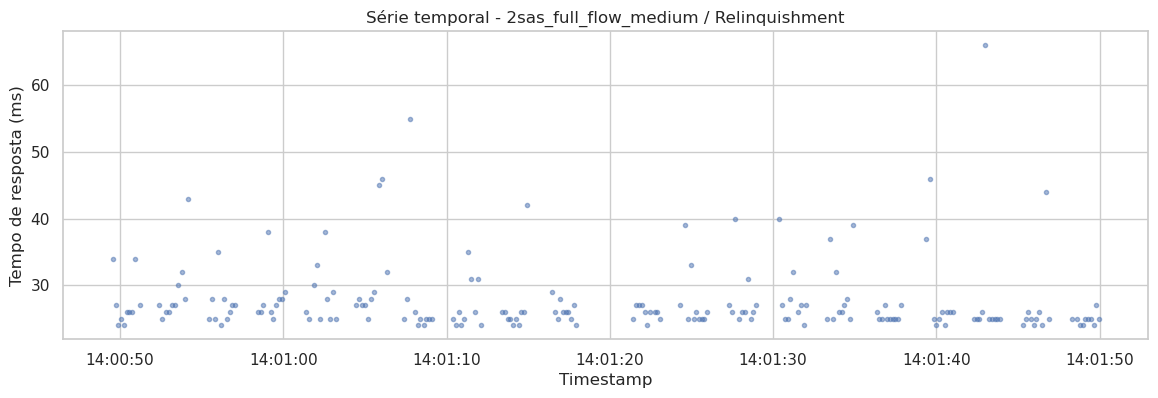

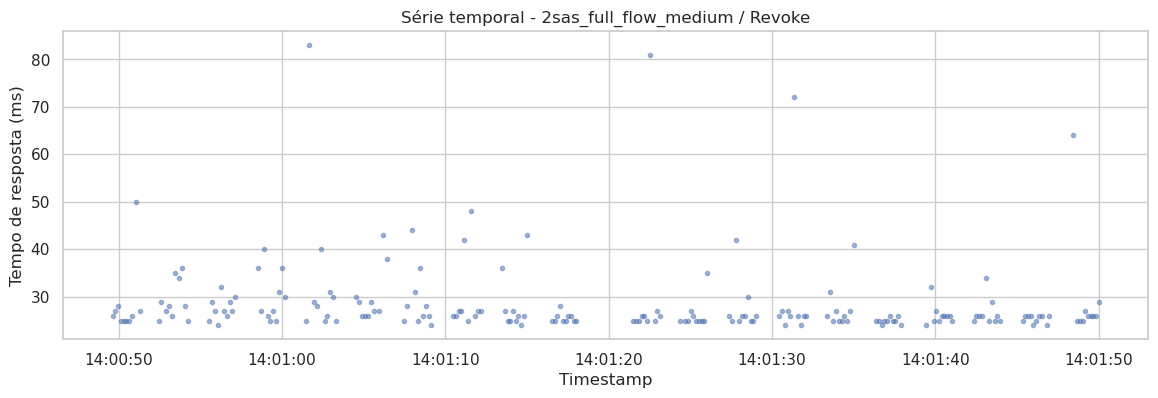

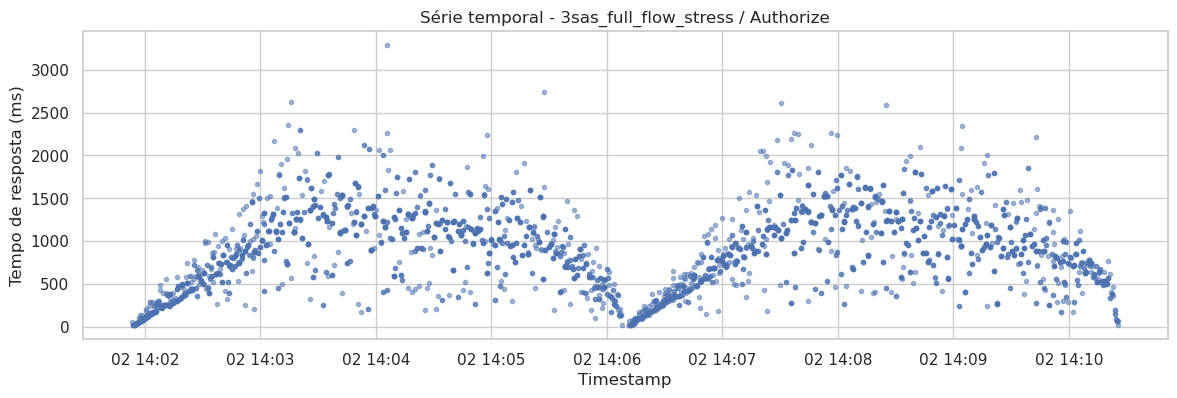

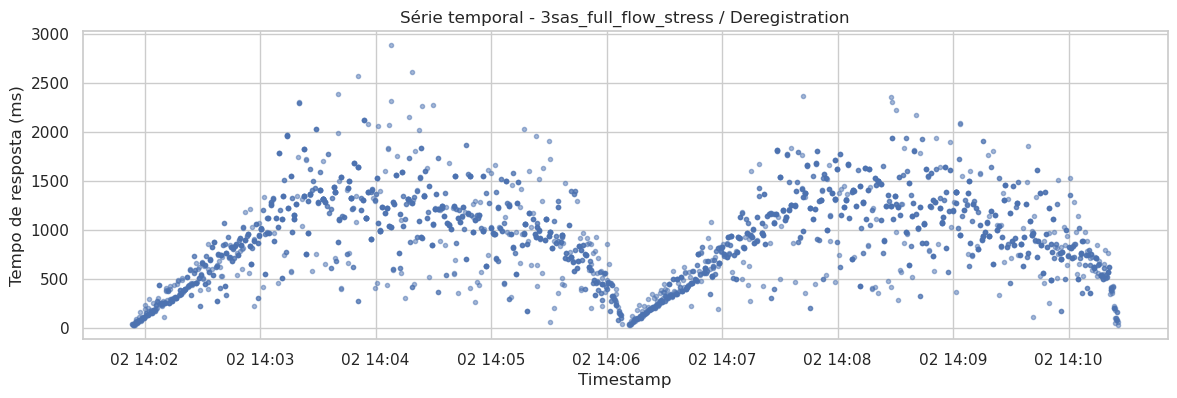

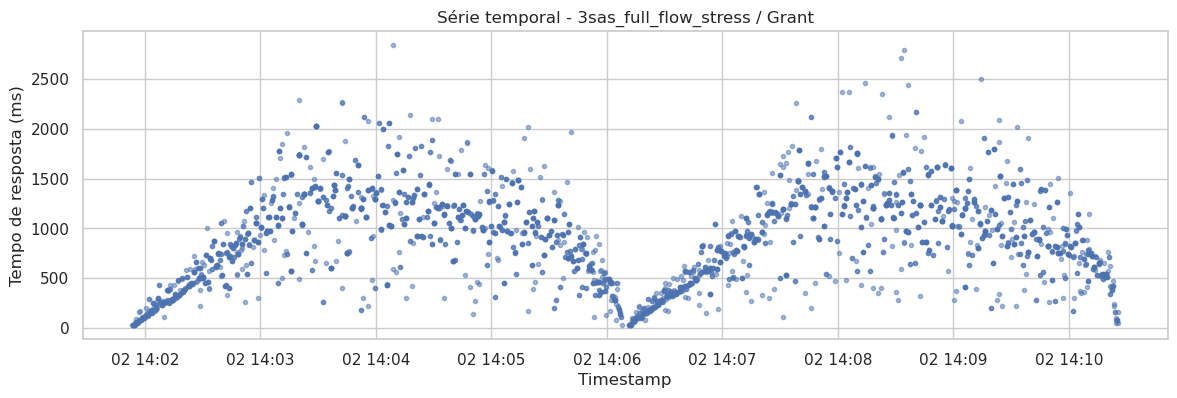

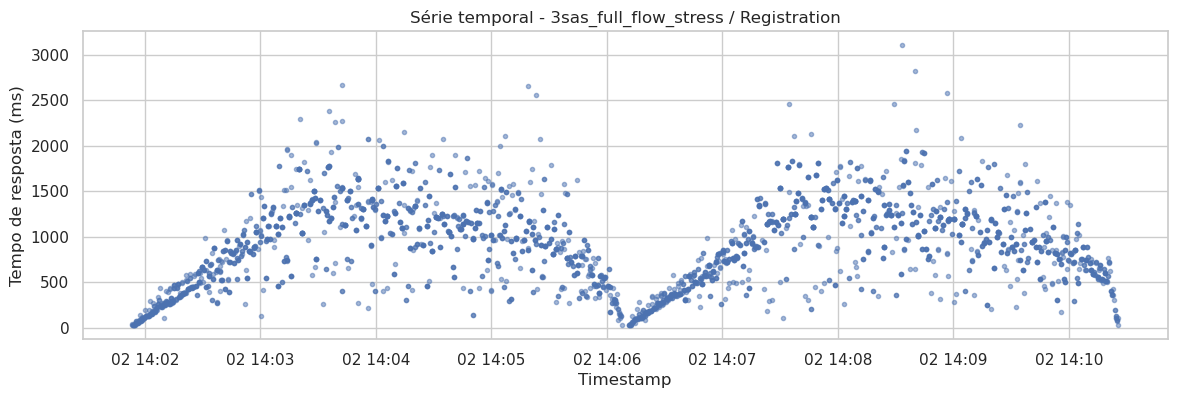

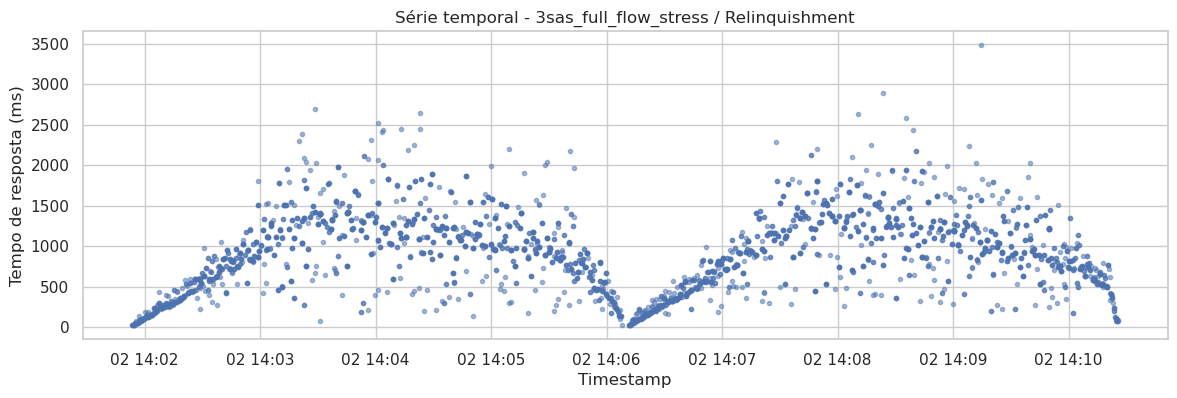

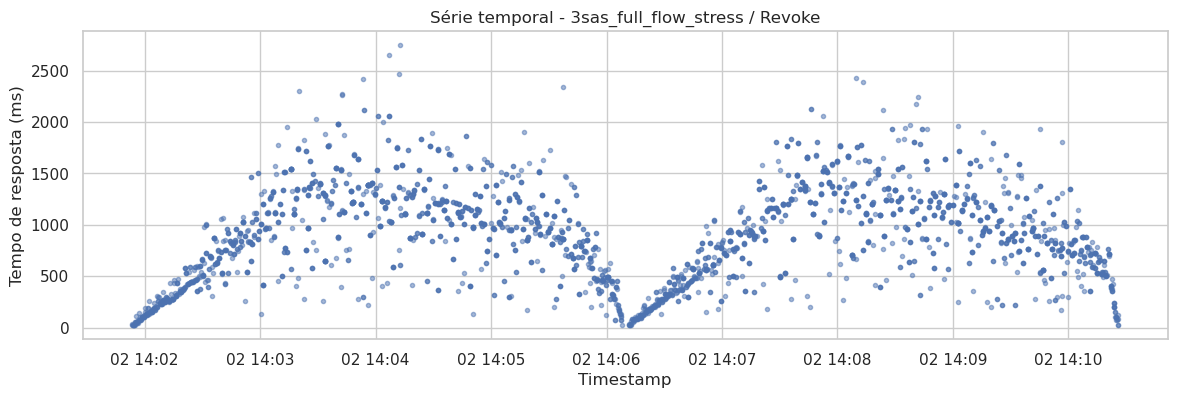

In [13]:
if not all_data.empty:
    for (scenario, req_type), group in all_data.groupby(['scenario', 'request_type']):
        plt.figure(figsize=(14,4))
        plt.plot(pd.to_datetime(group['timeStamp'], unit='ms'), group['elapsed'], marker='.', linestyle='', alpha=0.5)
        plt.title(f'Série temporal - {scenario} / {req_type}')
        plt.xlabel('Timestamp')
        plt.ylabel('Tempo de resposta (ms)')
        plt.show()
else:
    print('Nenhum dado carregado.')

## 6. Relatório de erros e falhas
Listando falhas e mensagens de erro, se houver.

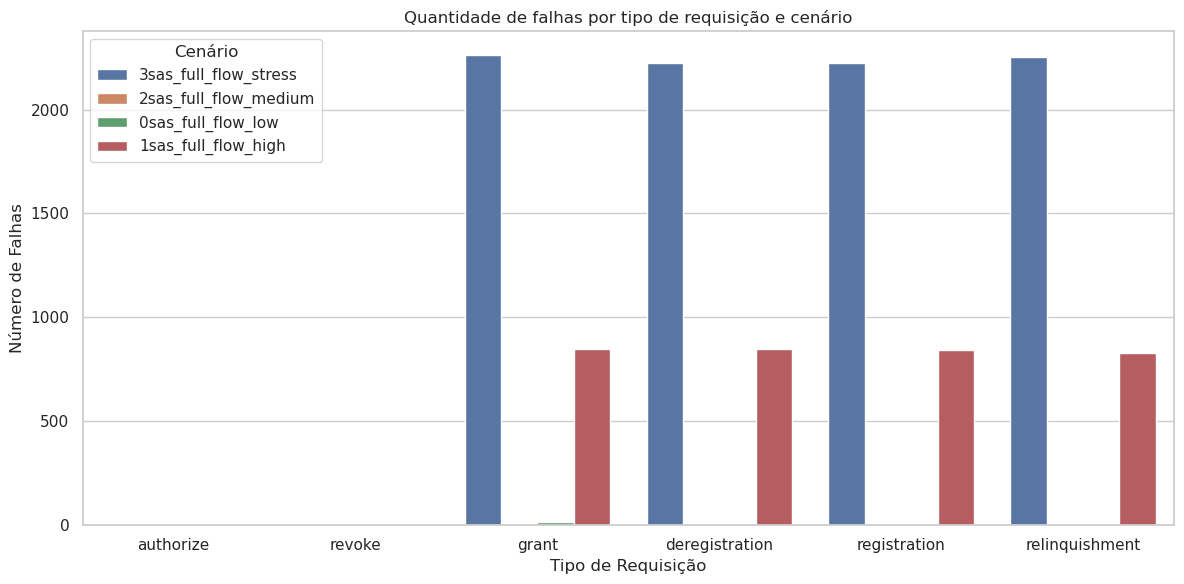

In [14]:
# Padronize as colunas antes de tudo
all_data['request_type'] = all_data['request_type'].astype(str).str.strip().str.lower()
all_data['scenario'] = all_data['scenario'].astype(str).str.strip().str.lower()

# Filtra erros como antes
erros = all_data[all_data['success'] == False].copy()

# Agrupa normalmente
contagem = erros.groupby(['request_type', 'scenario']).size().reset_index(name='falhas')

# Cria todos os pares possíveis (também padronizados)
tipos = all_data['request_type'].unique()
cenarios = all_data['scenario'].unique()
todos_pares = pd.MultiIndex.from_product([tipos, cenarios], names=['request_type', 'scenario']).to_frame(index=False)

# Faz o merge corretamente agora
contagem_completa = pd.merge(todos_pares, contagem, on=['request_type', 'scenario'], how='left').fillna(0)

# Converte falhas para inteiro (evita float no gráfico)
contagem_completa['falhas'] = contagem_completa['falhas'].astype(int)

plt.figure(figsize=(12, 6))
sns.barplot(data=contagem_completa, x='request_type', y='falhas', hue='scenario')
plt.title('Quantidade de falhas por tipo de requisição e cenário')
plt.xlabel('Tipo de Requisição')
plt.ylabel('Número de Falhas')
plt.legend(title='Cenário')
plt.tight_layout()
plt.show()

---
**Observações:**
- Este notebook pode ser expandido para análises mais avançadas, como correlação entre variáveis, análise de throughput, etc.
- Para dúvidas ou sugestões, edite ou abra uma issue no repositório.

Total de linhas em all_data: 26520


/tmp/ipykernel_101038/1904426009.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample('1S')       # janela de 1s
/tmp/ipykernel_101038/1904426009.py:49: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()               # conta requisições nessa janela


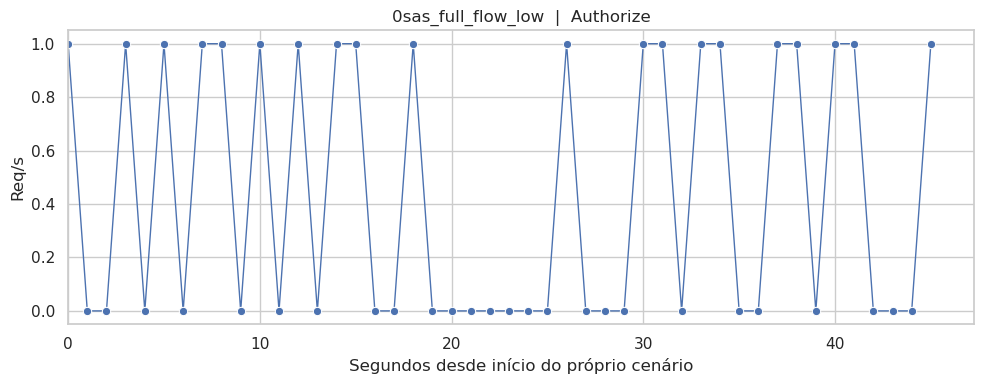

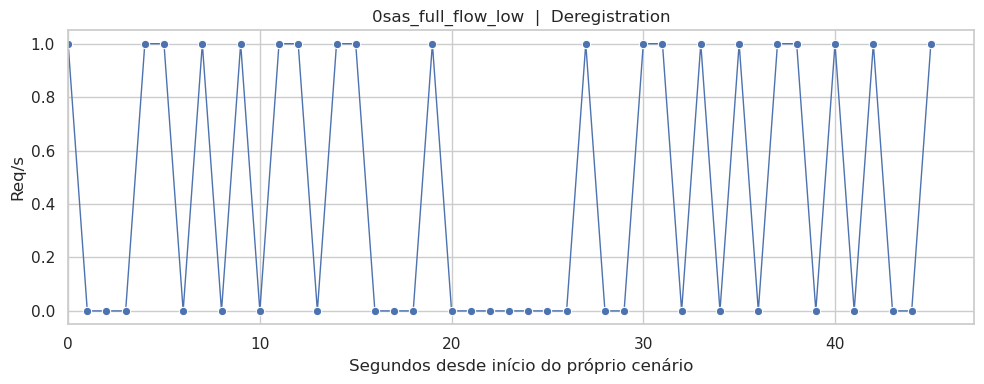

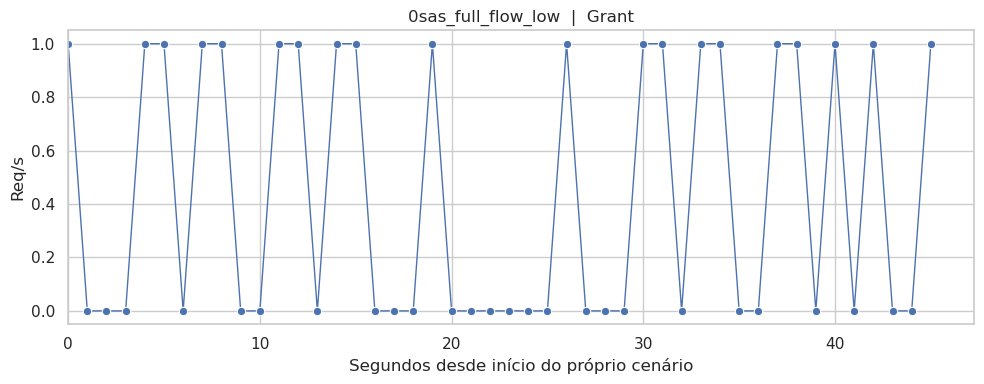

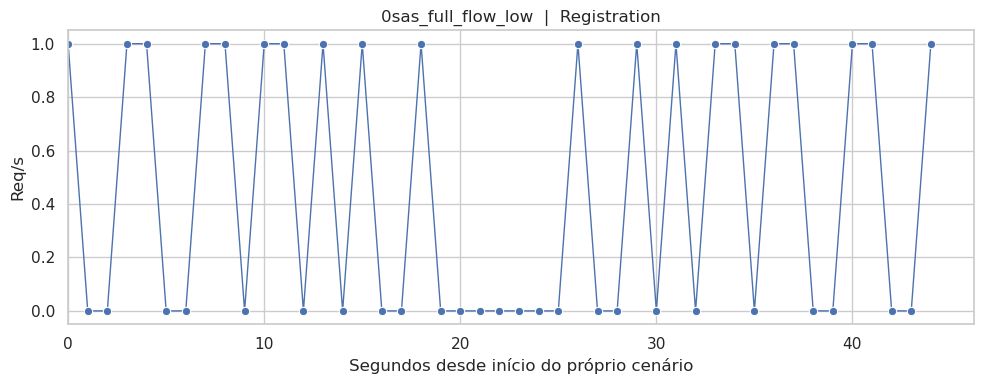

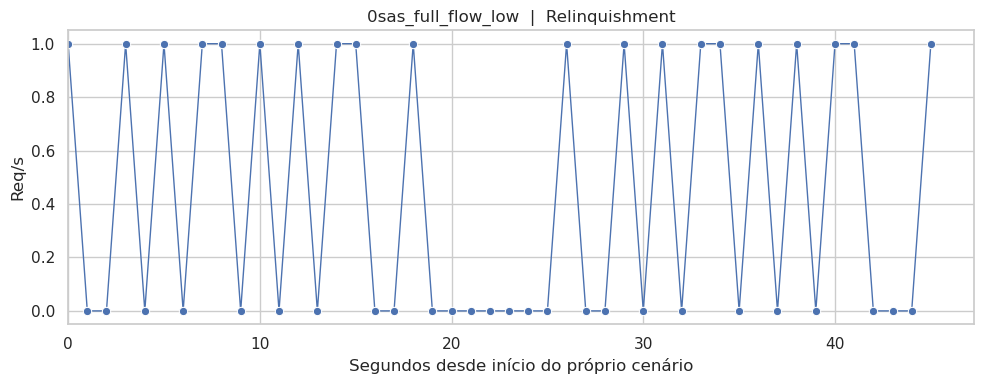

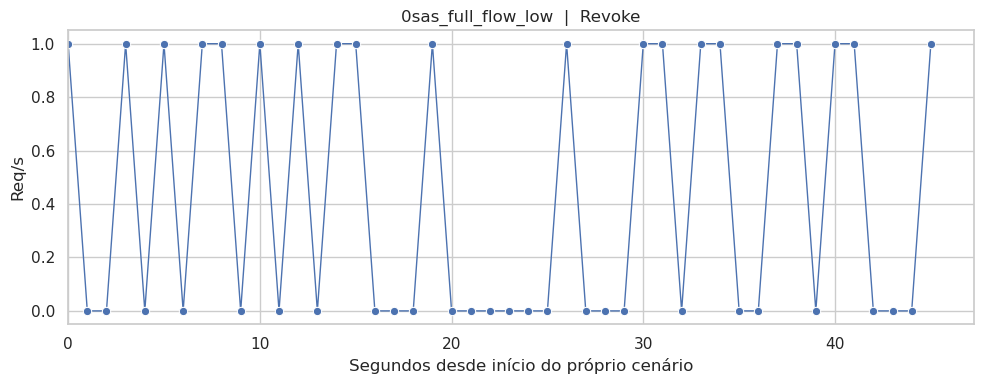

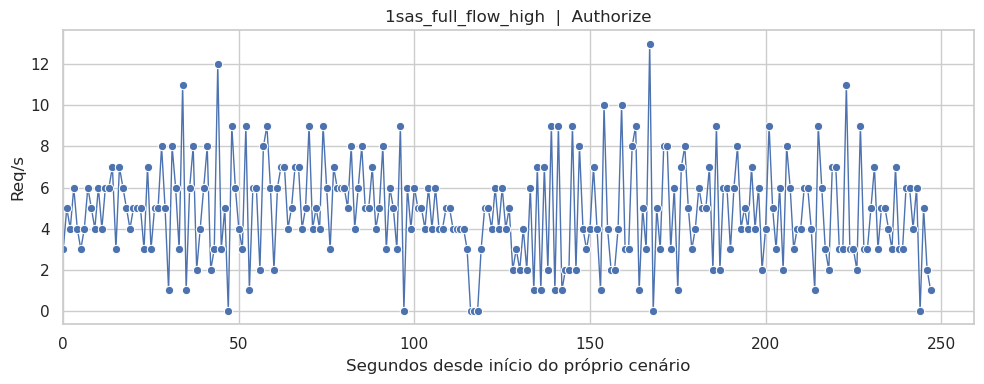

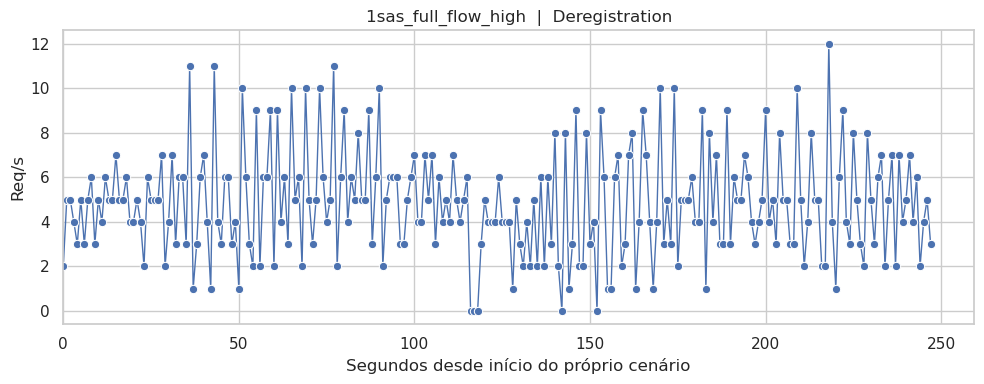

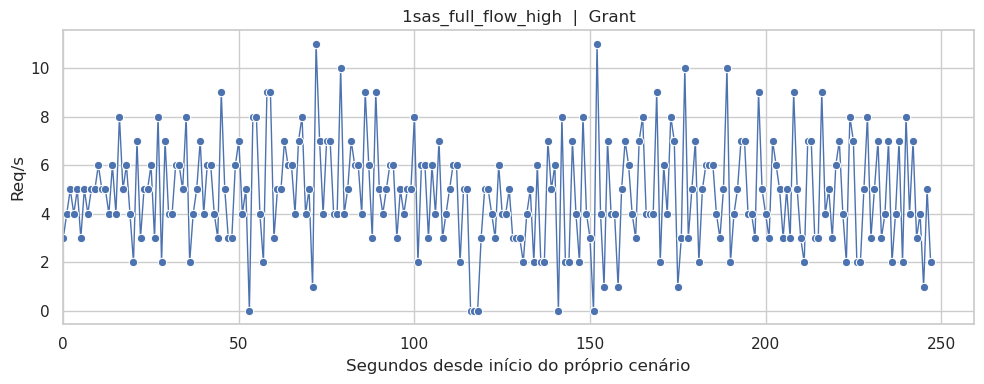

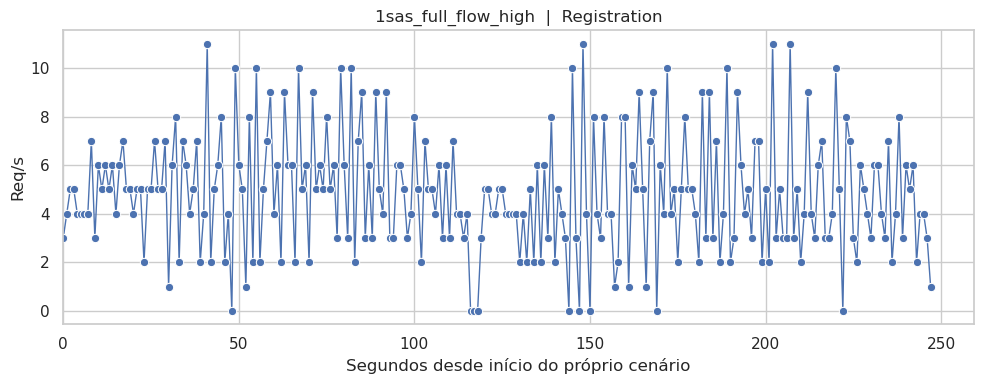

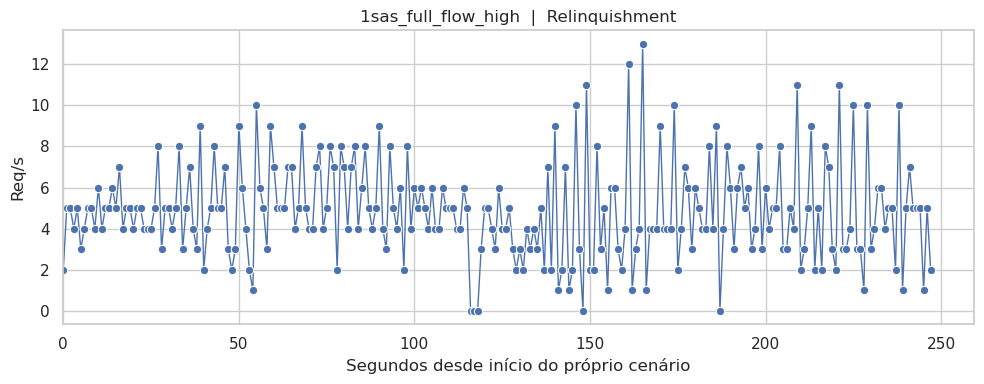

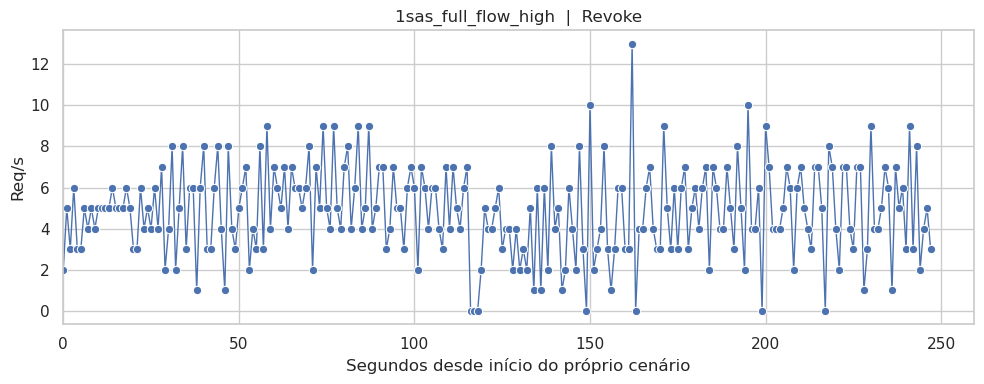

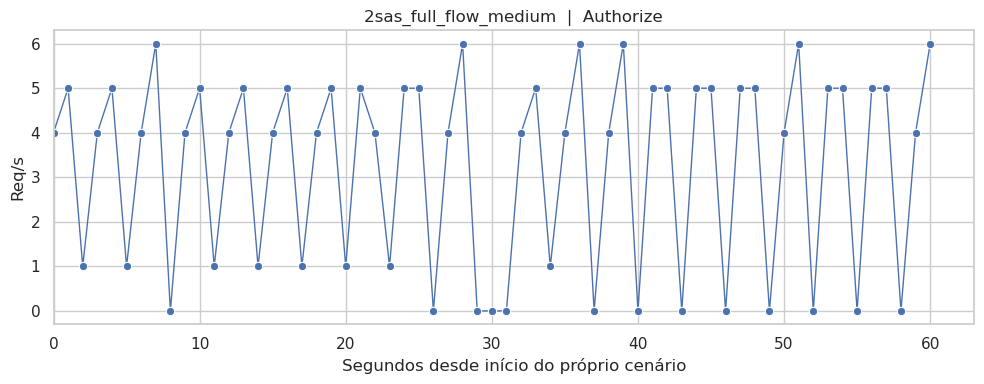

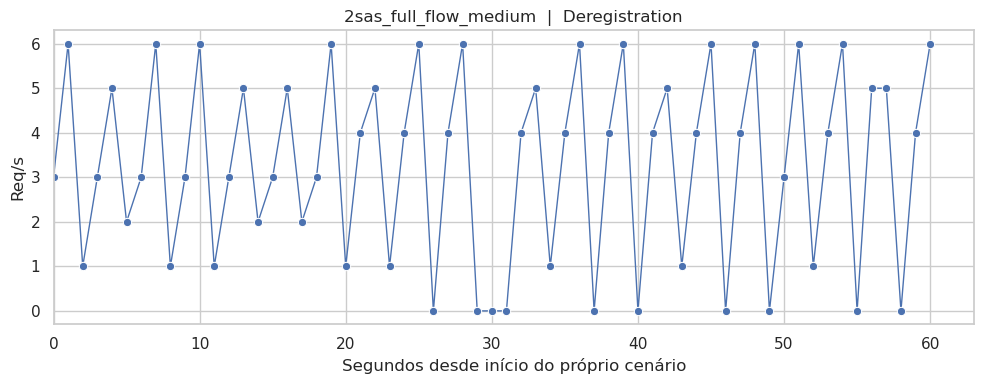

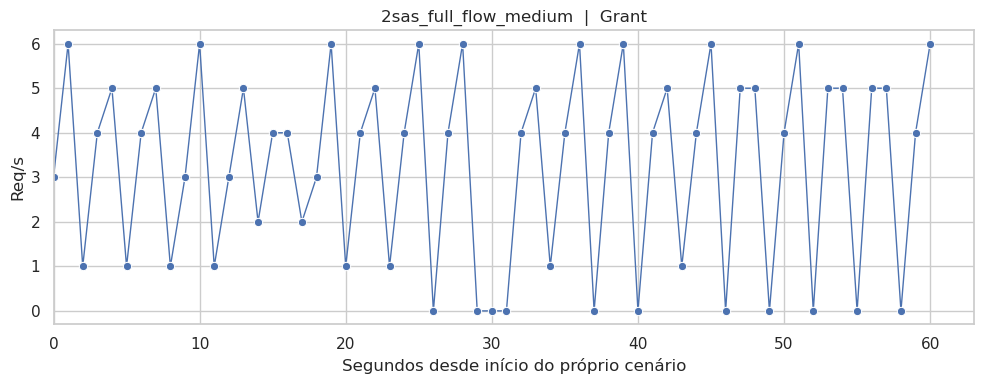

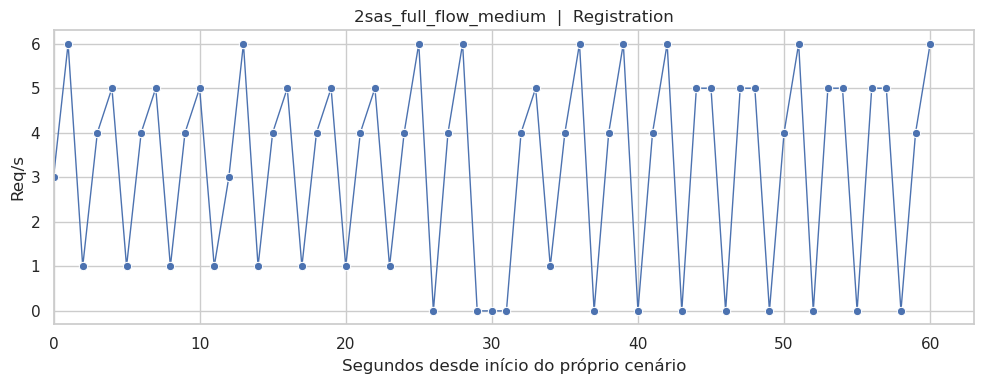

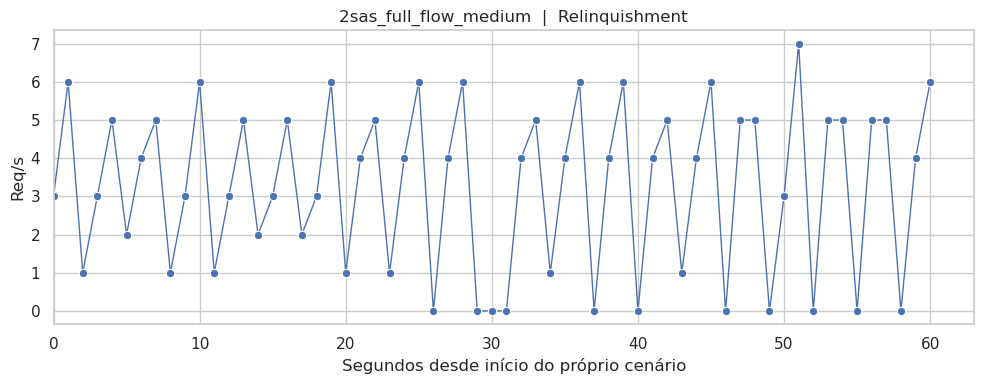

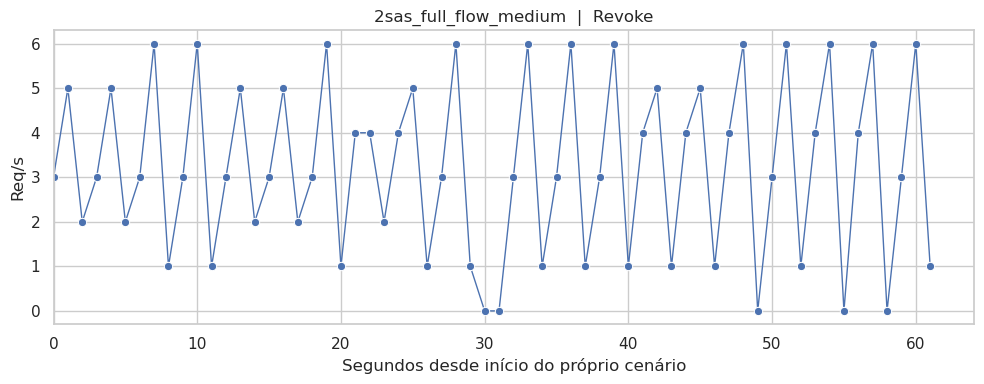

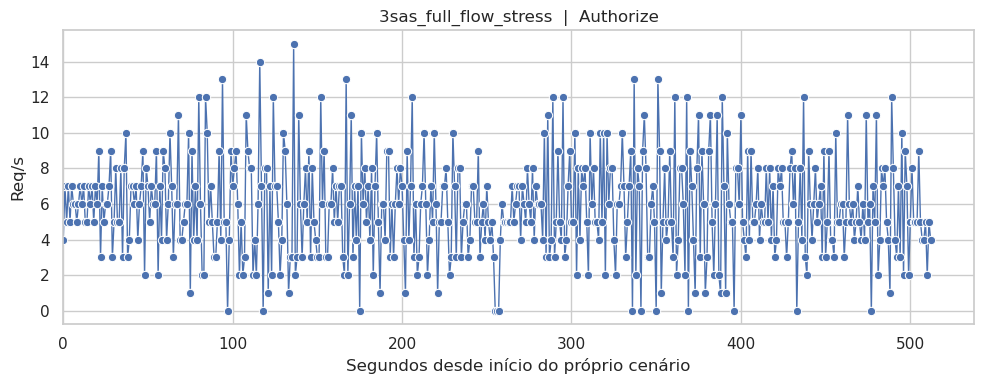

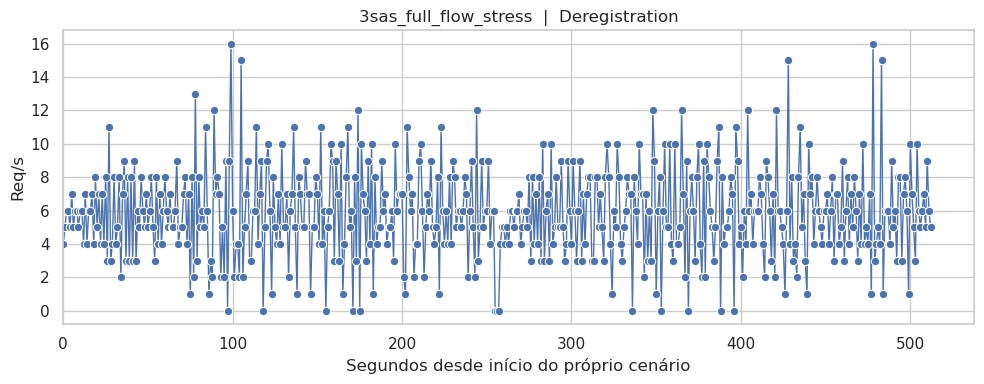

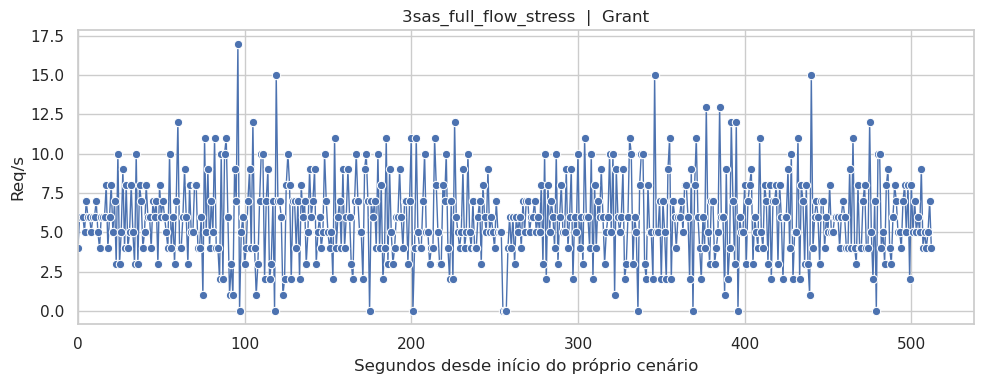

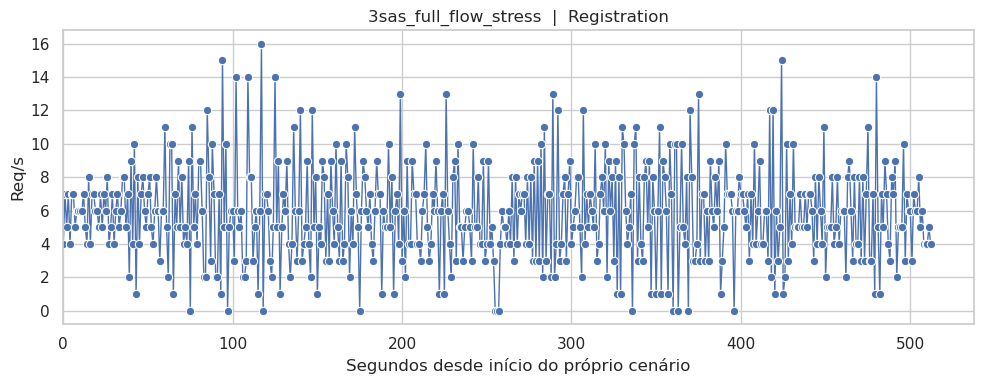

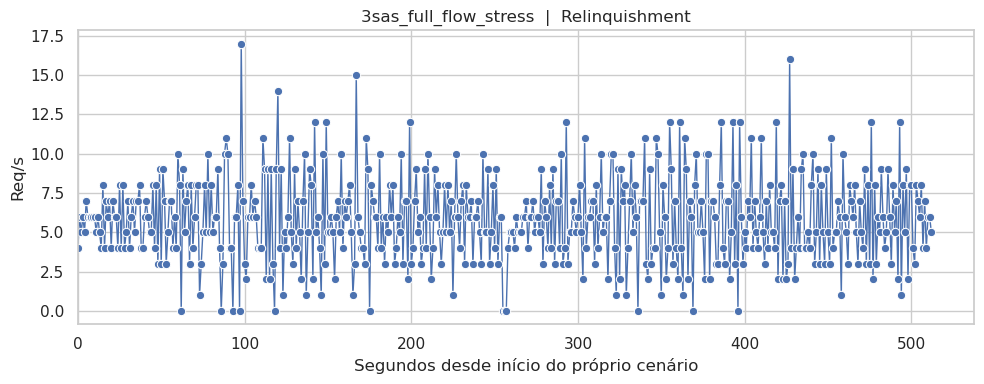

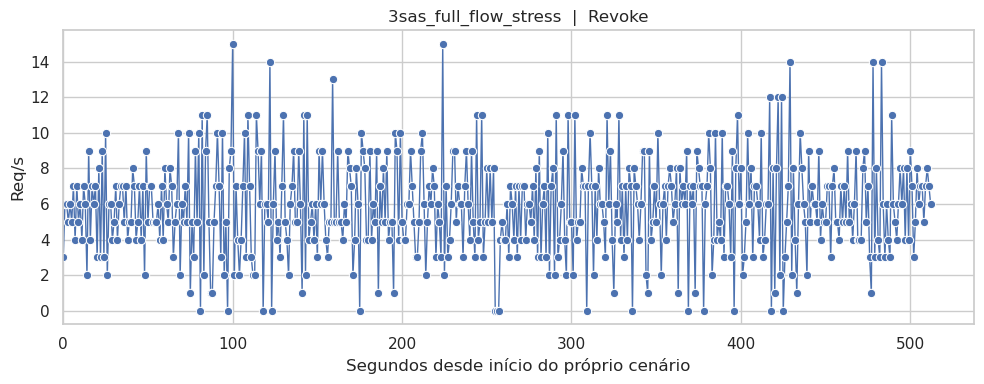

In [28]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# 1) Função para extrair cenário e tipo de requisição do path
def parse_metadata(file_path):
    parts = Path(file_path).parts
    # espera: results/<scenario>/<request_type>/nome.jtl
    return parts[1], parts[2]

# 2) Descobrir todos os .jtl e ler em um único DataFrame
RESULTS_DIR = 'results'
jtl_files = list(Path(RESULTS_DIR).rglob('*.jtl'))

dfs = []
for f in jtl_files:
    df = pd.read_csv(f)
    scenario, req_type = parse_metadata(f)
    df['scenario']     = scenario
    df['request_type'] = req_type
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)
print(f'Total de linhas em all_data: {len(all_data)}')

# 3) Converter timestamp para datetime
all_data['timeStamp'] = pd.to_datetime(all_data['timeStamp'], unit='ms')

#    e criar coluna de segundos relativos desde o início do teste
t0 = all_data['timeStamp'].min()
all_data['sec'] = (all_data['timeStamp'] - t0).dt.total_seconds()

# 4) Indexar por timeStamp e calcular throughput a cada 1 segundo
df = all_data.set_index('timeStamp')

tp = (
    df
    .groupby(['scenario','request_type'])
    .resample('1S')       # janela de 1s
    .size()               # conta requisições nessa janela
    .reset_index(name='req_per_s')
)

#    já temos timeStamp, mas vamos usar a coluna 'sec' para o gráfico:
tp['sec'] = (tp['timeStamp'] - t0).dt.total_seconds()

# 5) Calcular segundos relativos dentro de cada grupo
tp['sec_rel'] = (
    tp
    .groupby(['scenario', 'request_type'])['timeStamp']
    .transform(lambda ts: (ts - ts.min()).dt.total_seconds().astype(int))
)

# 6) Loop para gerar um figure distinto para cada cenário × request_type,
#    agora usando sec_rel em vez de timeStamp
for (scenario, req_type), sub in tp.groupby(['scenario','request_type']):
    plt.figure(figsize=(10,4))
    sns.lineplot(
        data=sub,
        x='sec_rel',       # começa em 0 para cada par
        y='req_per_s',
        marker='o',
        linewidth=1
    )
    plt.title(f'{scenario}  |  {req_type}')
    plt.xlabel('Segundos desde início do próprio cenário')
    plt.ylabel('Req/s')
    plt.xlim(0)           # força o mínimo em zero
    plt.tight_layout()
    plt.show()
